#1 Import library


In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns

#2 Loading Data

In [ ]:
rating_data = pd.read_csv("/content/drive/MyDrive/Movie Recommendation system/Data_movie_content-based/Data/ratings_small.csv")
rating_data = rating_data.drop(columns = ["timestamp"])

<Axes: >

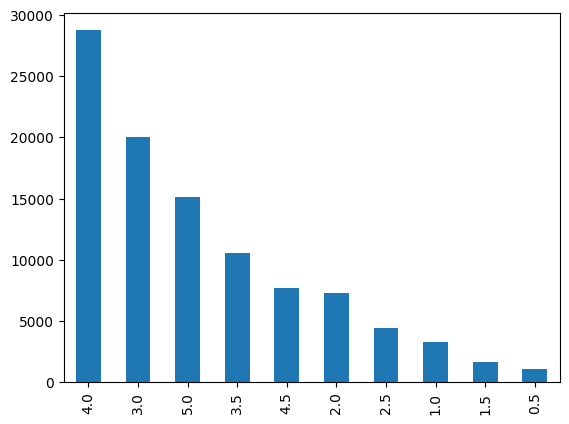

In [ ]:
rating_data["rating"].value_counts().plot(kind = "bar")

## Change DataFrame into matrix numpy and splitting data into training and testing set

In [ ]:
matrix_data = rating_data.to_numpy()
# test_matrix = test_data.to_numpy()

In [ ]:
# Index of movie and user-1
matrix_data[:,[0,1]] = matrix_data[:,[0,1]] - 1
matrix_data.shape

(100004, 3)

Split original data with training datasets (66%) and test datasets(33%)

In [ ]:
# Splitting the data into training set and testing set
from sklearn.model_selection import train_test_split

rate_train, rate_test = train_test_split(matrix_data, test_size=0.33, random_state=42)
print(rate_train.shape, rate_test.shape)

(67002, 3) (33002, 3)


#3.Matrix Factorization Using Singular Value Decomposition
The main idea behind the matrix factorization is we can discover the latent features, latent attribute between user with user, item with item without specify what is it.We call it the latent features since we don’t actually know what exactly features is, we only know that those will help us to express the relationship between Users and between Movies

##3.1 Build the MFSVD model
 In the diagonal matrix $\Sigma$ the singular values $\sigma_{i}$ in the diagonal is non-negative and decreasing: $\sigma_{1} \geq \sigma_{2} \geq \sigma_{3} \geq ... \geq \sigma_{r} \geq 0$, show how important the various columns of $U$ and rows of $V$ are. Therefore, $U_{1}$ is more important than $U_{2}$ and $U_{2}$ is more important than $U_{3},...$. Similar to $V_{1}$, $V_{2},...$.

 The word "important" here express which amount of values those columns or rows contribute to the original matrix

Using lower-rank matrix, we almost still have important information about the original matrix

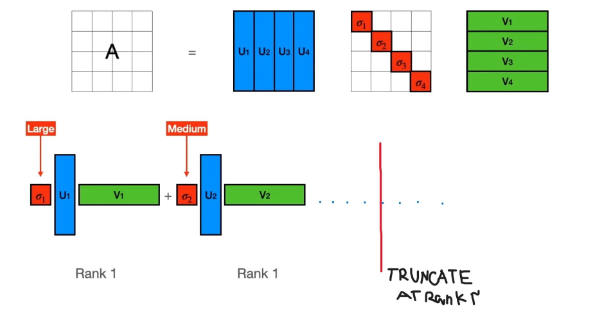

In [ ]:
print("Number of Movie:", len(set(rating_data["movieId"])))
print("Number of User:", len(set(rating_data["userId"])))
print("Total matrix element", len(set(rating_data["movieId"])) * len(set(rating_data["userId"])))

Number of Movie: 9066
Number of User: 671
Total matrix element 6083286


In [ ]:
class SVD(object):
  def __init__(self, data, rank, user_based = 1):
    self.raw_data = data
    self.rank = rank

    # number of user, items, ratings:
    self.n_users = int(np.max(self.raw_data[:,0]) + 1)
    self.n_items = int(np.max(self.raw_data[:,1]) + 1)
    self.n_objects = int(self.raw_data.shape[0])

    # Choose the way to normalize data:
    self.user_based = user_based

    # Make a copy of raw matrix to prepare for normalize:
    self.normal_matrix = self.raw_data.copy()

  def normalize(self):
      """
      We normalize the rating matrix:
      For each users, we calculate the mean of rating of movies that user vote for. Then subtract the rating with that mean value.
      """
      if self.user_based:
        user_col = 0
        item_col = 1
        n_objects = self.n_users
      else:
        user_col = 1
        item_col = 0
        n_objects = self.n_items

      # # Convert all value in rating matrix to integer value:
      self.normal_matrix = self.normal_matrix.astype("float32")

      # Create a array contain mean value for each object:
      self.mean = np.zeros((n_objects,))
      # Compute mean and subtract rating for each user:
      for n in tqdm(range(n_objects)):
        # find index row rating which rated by user n or rate for movie n (depend on user_based or item_based)
        ids = np.where(self.normal_matrix[:,user_col] == n)

        # Find the rating column
        rating = self.normal_matrix[ids,2]
        # Find the mean of rating column
        mean_value = np.mean(rating)
        # Check whether mean_value is none or not (since sometime rating column is empty -> mean_value = NULL)
        if np.isnan(mean_value):
          mean_value = 0
        self.mean[n] = mean_value
        # normalize:
        self.normal_matrix[ids,2] =  self.normal_matrix[ids,2] - mean_value

        # Change the normal_matrix into sparse normal matrix:
      self.normal_matrix = sparse.coo_matrix((self.normal_matrix[:, 2],
          (self.normal_matrix[:, 1], self.normal_matrix[:, 0])), (self.n_items, self.n_users))
      self.normal_matrix = self.normal_matrix.todense()


  def SVD(self):
    self.normalize()
    # Singular value decomposition:
    U,S,V_T = np.linalg.svd(self.normal_matrix, full_matrices = False)
    # left singular vector
    Uk = U[:,:self.rank]
    # singular matrix
    self.S = S
    S = np.diag(S)
    Sk = S[:self.rank,:self.rank]
    # Right singular vector:
    V_Tk = V_T[:self.rank, :]

    # Approximation matrix:
    self.res = Uk @ Sk @ V_Tk

  def plot_singular(self):
    plt.semilogy(np.diag(self.S))
    plt.title('Singular values')
    plt.show()


  def predict(self,user,movie):
    predict = self.res[movie,user]
    if self.user_based:
        predict = predict + self.mean[user]
    else:
      predict = predict + self.mean[movie]
    if predict < 0:
      predict = 0
    elif predict > 5:
      predict = 5
    return predict

  def predict_eachUser(self,rate_test,sort):
    predictDict = dict()
    n_users = int(np.max(rate_test[:,0])) + 1
    for u in range(n_users):
      idxDict = dict()
      idx = np.where(rate_test[:,0] == u)[0]
      for i in idx:
        idxDict[i] = self.predict(int(rate_test[i,0]), int(rate_test[i,1]))
      if (sort == 1):
        idxDict = dict(sorted(idxDict.items(), key = lambda x : x[1], reverse = True))
      ratings = [1 if r > self.mean[u] else 0 for r in idxDict.values()]
      predictDict[u] = [ratings,list(idxDict.keys())]
    return predictDict

  def MSE(self, datasets):
    MSE = 0
    n_tests = datasets.shape[0]
    for i in range(n_tests):
      pred = self.predict(int(datasets[i,0]),int(datasets[i,1]))
      error = (datasets[i,2] - pred)**2
      MSE += error
    MSE = (1/(n_tests)) * MSE
    return MSE

In [ ]:
mf = SVD(rate_train, rank = 10,user_based = 1)
mf.SVD()

##3.2 Fine Tuning

In [ ]:
rank_list = [5,10,15,20,25,30,35,40]
MSE_test = []
MSE_train = []

In [ ]:
for r in rank_list:
  mf = SVD(rate_train, rank = r,user_based = 1)
  mf.SVD()
  MSE_test.append(mf.MSE(rate_test))
  MSE_train.append(mf.MSE(rate_train))

100%|██████████| 671/671 [00:00<00:00, 6021.00it/s]


In [ ]:
MSE_test

[0.882073652911572,
 0.877619780894483,
 0.8808232123453967,
 0.8833518721428427,
 0.8866217731165362,
 0.8884567756453142,
 0.8902900022699625,
 0.8933138069738664]

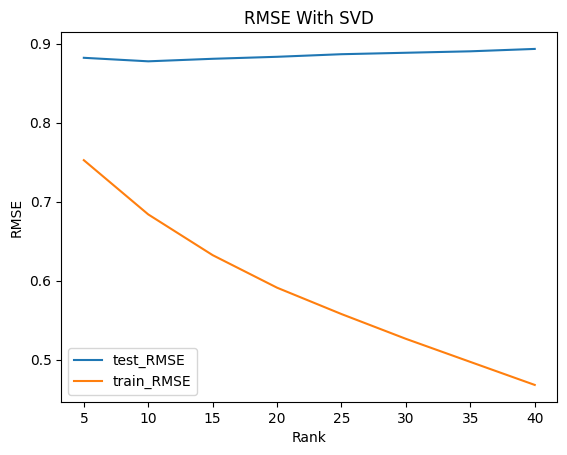

In [ ]:
import matplotlib.pyplot as plt
plt.title("MSE With SVD")
plt.plot(rank_list,MSE_test,label = "test_MSE")
plt.plot(rank_list,MSE_train,label = "train_MSE")
plt.xlabel("Rank")
plt.ylabel("MSE")
plt.legend()
plt.show()

=> With rank = 10, MSE_test is nearly smallest


#4.Evaluation
Strategy: From the matrix I build from training datasets, I will try to predict the rating value for each movie of each user

1) Compute the MSE loss value.

2) To evaluate the quality of recommender:
- rating > mean then user like that movie(1) and otherwise don't like (0) or in prediction rating > mean then recommend that film, otherwise not

- Recommend with 2 orders: No order and Descending order of rating
- Compute Precision@K, Recall@K and F1@K with No order and Descending order of rating

3) To evaluate the quality of ranking:
  
- Compute MAP@K and nDCG to evaluate with 2 ways of recommendation order


##4.1 Recommend with no order and with Descending order of rating

In [ ]:
# Compute the Avg ratings of each user:
def buildBinaryDict(dataset,indxSort):
  truthDict = dict()
  number_user = int(np.max(dataset[:,0])) + 1
  for u in range(number_user):
    ratings = dataset[indxSort[u],2]
    mean_rating = np.mean(ratings)
    ratingBinary = [1 if rating >= mean_rating else 0 for rating in ratings]
    truthDict[u] = ratingBinary
  return truthDict





In [ ]:
mf = SVD(rate_train, rank = 10,user_based = 1)
mf.SVD()

100%|██████████| 671/671 [00:00<00:00, 6987.71it/s]


In [ ]:
predictDictSort = mf.predict_eachUser(rate_test, sort = 1)
predictDict = mf.predict_eachUser(rate_test, sort = 0)

In [ ]:
idxSort = []
for u in predictDictSort.keys():
  idxSort.append(predictDictSort[u][1])
truthDict = buildBinaryDict(rate_test,idxSort)

In [ ]:
idx = []
for u in predictDict.keys():
  idx.append(predictDict[u][1])
truthDictSort = buildBinaryDict(rate_test,idx)

##4.2 Compute Precision@K, Recall@K, F1@K, MAP@K



In [ ]:
def PrecisionAtK(predictList, truthList,K):
  relevent_item = 0
  recommend_item = 0
  recommend = predictList
  total_recommend = sum(recommend)
  number_recommend = K if K < total_recommend else total_recommend
  for i in range(len(recommend)):
      if recommend[i] == 1:
        recommend_item += 1
        if truthList[i] == 1:
          relevent_item += 1
      if recommend_item == number_recommend:
        break

  if recommend_item == 0:
    return None

  return relevent_item  / number_recommend


def Precision_test_data(predictDict, truthDict,K):
  precision = 0
  number_user_recommend = 0
  for u in range(len(predictDict.keys())):
    predictList = predictDict[u][0]
    truthList = truthDict[u]
    precision_user = PrecisionAtK(predictList, truthList,K)
    if precision_user:
      precision += precision_user
      # print(precision_user)
      number_user_recommend += 1

  return precision / number_user_recommend

In [ ]:
def AP_K(predictArray, truthArray, K):
  count_rel = 0
  AP_K = 0
  for k in range(1,K):
      if PrecisionAtK(predictArray,truthArray,k):
        AP_K += PrecisionAtK(predictArray,truthArray,k)
        count_rel += 1
  if count_rel != 0:
    AP_K = AP_K/count_rel
  return AP_K




In [ ]:
def MAP_score(predictDict, truthDict,K):
  number_user = len(predictDict.keys())
  MAP_K = 0
  for u in range(number_user):
    predictArray = predictDict[u][0]
    truthArray = truthDict[u]
    MAP_K += AP_K(predictArray, truthArray,K)

  return MAP_K/number_user


In [ ]:
K_list = [2,5,10,15,20,25,30,35,40,45,50,55,60,70,75,80,90,100]

In [ ]:
MAP_list = []
MAP_listSort = []
for k in K_list:
  MAP_list.append(MAP_score(predictDict,truthDict,k))
  MAP_listSort.append(MAP_score(predictDictSort,truthDictSort,k))

In [ ]:
def RecallAtK(predictList, truthList,K):
  relevent_item = 0
  recommend_item = 0
  recommend = predictList
  total_relevent = sum(truthList)
  total_recommend = sum(recommend)
  number_recommend = K if K < total_recommend else total_recommend
  if total_relevent == 0 :
     return None
  for i in range(len(recommend)):
      if recommend[i] == 1:
        recommend_item += 1
        if truthList[i] == 1:
          relevent_item += 1
      if recommend_item == number_recommend:
        break


  return relevent_item  / total_relevent

In [ ]:
def Recall_test_data(predictDict, truthDict,K):
  recall = 0
  number_user_recommend = 0
  for u in range(len(predictDict.keys())):
    predictList = predictDict[u][0]
    truthList = truthDict[u]
    recall_user = RecallAtK(predictList, truthList,K)
    if recall_user:
      recall += recall_user
      # print(precision_user)
      number_user_recommend += 1

  return recall / number_user_recommend

In [ ]:
PrecisionatK_List = []
RecallK_List = []
for k in K_list:
  PrecisionatK_List.append(Precision_test_data(predictDict, truthDict,k))
  RecallK_List.append(Recall_test_data(predictDict, truthDict, k))

In [ ]:
def f1_score(precision, recall):
  return 2/ (1/precision + 1/recall)

In [ ]:
f1_score_list = []
for i in range(len(K_list)):
  f1_score_list.append(f1_score(PrecisionatK_List[i],RecallK_List[i]))

In [ ]:
PrecisionatK_ListSort = []
RecallK_ListSort = []
for k in K_list:
  PrecisionatK_ListSort.append(Precision_test_data(predictDictSort, truthDictSort,k))
  RecallK_ListSort.append(Recall_test_data(predictDictSort, truthDictSort, k))

In [ ]:
f1_score_listSort = []
for i in range(len(K_list)):
  f1_score_listSort.append(f1_score(PrecisionatK_ListSort[i],RecallK_ListSort[i]))

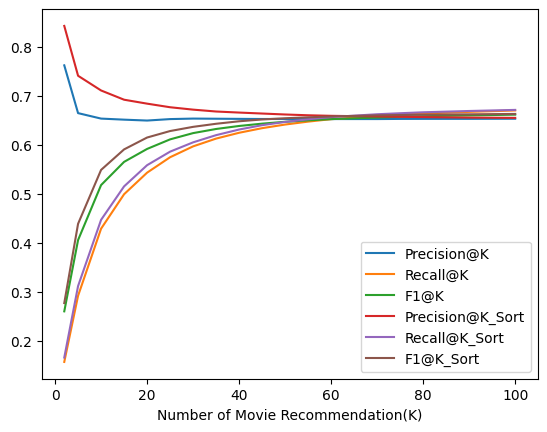

In [ ]:
plt.plot(K_list,PrecisionatK_List, label = "Precision@K")
plt.plot(K_list,RecallK_List, label = "Recall@K")
plt.plot(K_list, f1_score_list, label = "F1@K")
plt.plot(K_list,PrecisionatK_ListSort, label = "Precision@K_Sort")
plt.plot(K_list,RecallK_ListSort, label = "Recall@K_Sort")
plt.plot(K_list, f1_score_listSort, label = "F1@K_Sort")
plt.xlabel("Number of Movie Recommendation(K)")
plt.legend()
plt.show()

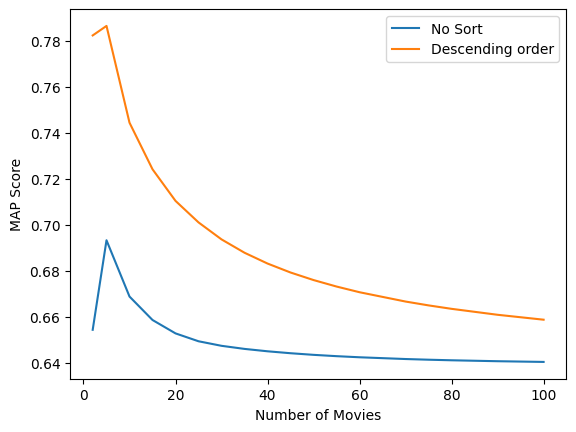

In [ ]:
plt.plot(K_list,MAP_list,label = "No Sort")
plt.plot(K_list,MAP_listSort,label = "Descending order")
plt.xlabel("Number of Movies")
plt.ylabel("MAP Score")
plt.legend()
plt.show()

##4.3 nDCG score

In [ ]:
def DCGAtK(predictList, truthList,K):
  relevent_item = 0
  recommend_item = 0
  recommend = predictList
  DCG = 0
  total_recommend = sum(recommend)
  number_recommend = K if K < total_recommend else total_recommend
  for i in range(total_recommend):
        if recommend[i] == 1:
          recommend_item += 1
          if truthList[i] == 1:
            DCG += 1 / np.log(recommend_item + 1)
        if recommend_item == number_recommend:
          break
  return DCG

In [ ]:
def Ideal_DCG(truthListSort,K):
  K = K if K < len(truthListSort) else len(truthListSort)
  ideal_DCG = 0
  for i in range(1,K+1):
    if truthListSort[i-1] == 0:
      break
    ideal_DCG += 1/np.log(i + 1)

  return ideal_DCG

In [ ]:
def nDCG_score (predictDict, truthDict,K=100):
  numberUsers = len(predictDict.keys())
  nDCG_score = 0
  for indx in predictDict.keys():
    predictList = predictDict[indx][0]
    truthList = truthDict[indx]
    DCG = DCGAtK(predictList, truthList,K)
    ideal_DCG = Ideal_DCG(sorted(truthList,reverse = True),K)
    nDCG_score += DCG/ideal_DCG

  nDCG_score = nDCG_score/numberUsers

  return nDCG_score



In [ ]:
nDCGScore = []
nDCGScoreSort = []
for n in K_list :
  score = nDCG_score (predictDict,truthDict,K=n)
  scoreSort = nDCG_score (predictDictSort,truthDictSort,K=n)
  nDCGScore.append(score)
  nDCGScoreSort.append(scoreSort)
  print("Number movies: ",n," nCDG score: ",score)

Number movies:  2  nCDG score:  0.6182069056807897
Number movies:  5  nCDG score:  0.577228421907606
Number movies:  10  nCDG score:  0.5414906563624577
Number movies:  15  nCDG score:  0.5241087545291647
Number movies:  20  nCDG score:  0.5111893827407239
Number movies:  25  nCDG score:  0.5037268366889721
Number movies:  30  nCDG score:  0.4967929134992367
Number movies:  35  nCDG score:  0.49060775304277965
Number movies:  40  nCDG score:  0.48573255999727466
Number movies:  45  nCDG score:  0.4817100142626789
Number movies:  50  nCDG score:  0.4782412279172161
Number movies:  55  nCDG score:  0.4755287386547637
Number movies:  60  nCDG score:  0.4734492854381053
Number movies:  70  nCDG score:  0.4703762621589376
Number movies:  75  nCDG score:  0.46929862467361283
Number movies:  80  nCDG score:  0.4683722495665389
Number movies:  90  nCDG score:  0.4670230266348384
Number movies:  100  nCDG score:  0.46582518014832597


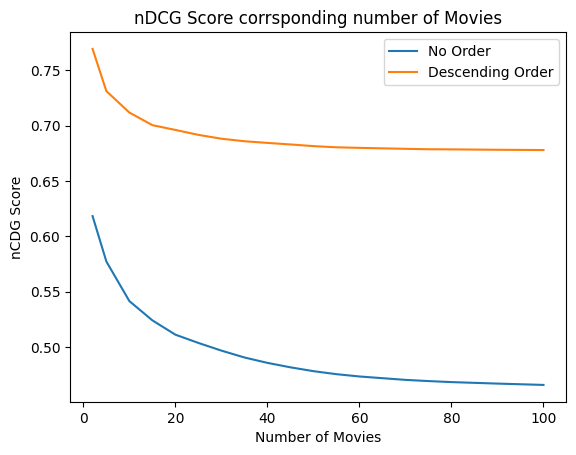

In [ ]:
plt.plot(K_list,nDCGScore, label = "No Order")
plt.plot(K_list,nDCGScoreSort, label = "Descending Order")
plt.xlabel("Number of Movies")
plt.ylabel("nCDG Score")
plt.title("nDCG Score corrsponding number of Movies")
plt.legend()
plt.show()